In [1]:
!pip -q install pybboxes
!pip -q install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.7 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import os
import pandas as pd
import pickle
from tqdm.auto import tqdm
import pybboxes as pybbx
from matplotlib import pyplot as plt
import math
import copy


import torch
from torch.utils.data import Dataset
from torch import nn
from torch.nn import functional as F

from torchvision.models import resnet
import torchvision.transforms as transforms
from torchmetrics import Accuracy

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UCODE_DICT = '/content/drive/MyDrive/Resource/Data/HWDB1.1-bitmap64-ucode-hannom-v2-tst_seen-label-set-ucode.pkl'

# Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/
# !pip install kaggle
!mkdir -v ~/.kaggle

!cp -f "/content/drive/MyDrive/Thesis Resource/kaggle.json" ~/.kaggle
!kaggle datasets download -d ngcthunhb/nomdataset-crops

/content
mkdir: created directory '/root/.kaggle'
Dataset URL: https://www.kaggle.com/datasets/ngcthunhb/nomdataset-crops
License(s): unknown
 99% 179M/182M [00:02<00:00, 92.2MB/s]
100% 182M/182M [00:02<00:00, 87.3MB/s]


In [5]:
!unzip -q /content/nomdataset-crops.zip -d dataset/

## NomImageDataset - For loading raw-cropped images

In [ ]:
# Dataset class for inputting YoloV5
class NomImageDataset(Dataset):
    def __init__(self, image_dir, annotation_file, unicode_dict_path, image_size=(224, 224), transform=None):
        self.root_dir = image_dir
        self.label_list = list()
        self.image_list = list()
        self.unicode_dict = dict()
        self.transform = transform
        self.image_size = image_size
        self.n_crop = 0

        with open(unicode_dict_path, 'rb') as f:
            tmp = pickle.load(f)
            tmp = sorted(list(tmp.keys()))
        for idx, k in enumerate(tmp):
            self.unicode_dict[k] = idx

        with open(annotation_file, 'r') as f:
            for line in tqdm(f):
                line = line.strip().split(',')
                image_name, label = line
                label = label.strip()
                image_path = os.path.join(self.root_dir, image_name)

                self.image_list.append(image_path)
                try:
                    self.label_list.append(self.unicode_dict[label])
                except:
                    self.label_list.append(self.unicode_dict['UNK'])
                    # print(f'Unknown label: {label}')

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        x_image = cv2.imread(self.image_list[idx])
        y_label = self.label_list[idx]
        x_image = cv2.cvtColor(x_image, cv2.COLOR_BGR2RGB)

        if self.transform:
            x_image = self.transform(x_image)
        else:
            x_image = x_image *  1.0 / 255
            x_image = cv2.resize(x_image, self.image_size, interpolation=cv2.INTER_LANCZOS4)
            # x_image = (x_image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
            x_image = torch.from_numpy(x_image).permute(2, 0, 1).float()
        y_label = torch.tensor(y_label, dtype=torch.long)
        return x_image, y_label

# opt = dict(
#     image_dir = '../NomDataset/datasets/mono-domain-datasets/tale-of-kieu/1871/1871-raw-images',
#     annotation_file = '../TempResources/ToK1871.txt',
#     unicode_dict_path = '../NomDataset/HWDB1.1-bitmap64-ucode-hannom-v2-tst-label-set-ucode.pkl',
#     transform = None,
# )
# dataset = NomImageDataset(**opt)

# from matplotlib import pyplot as plt
# img = dataset[2][0]
# detBoxes = dataset[2][1]


# textLabel = []
# for box in detBoxes:
#     x_tl, y_tl, x_br, y_br, label = box
#     cv2.rectangle(img, (x_tl, y_tl), (x_br, y_br), (0, 255, 0), 2)
#     cv2.putText(img, label, (x_tl, y_tl), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
#     textLabel.append(chr(int(label, 16)))
# plt.imshow(img)
# plt.show()

# print(textLabel)

class ImageCropDataset(Dataset):
    """ Image Crop Dataset Loader, used for loading Crop images and labels of crop image

    Args:
        crop_path (str): Path to the directory containing the crop images.
        label_path (str): Path to the file containing the labels of the crop images.
        input_size (tuple(int, int)): Image size to return.
        ucode_dict_path (str): Path to the file containing the unicode dictionary. For translate unicode to dictionary index
        transforms (Callable): Transforms to apply to the crop images.

    """
    def __init__(self, crop_path : str, label_path : str, input_size, ucode_dict : dict, transforms):
        self.crop_path = crop_path
        self.label_path = label_path
        self.ucode_dict = ucode_dict
        self.transforms = transforms

        self.input_size = input_size
        self.num_labels = 0

        self.crop_list = []
        self.labels_list = []

        def read_crop_and_label(crop_path, label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    line = line.split(', ')
                    self.labels_list.append(line[1].strip())
                    crop = line[0].strip()
                    # Check path exists
                    if not os.path.exists(os.path.join(crop_path, crop)):
                        raise FileNotFoundError(f'Crop image {os.path.join(crop_path, crop)} not found')
                    else:
                        self.crop_list.append(crop)

        read_crop_and_label(crop_path, label_path)

        assert self.crop_list is not None, 'No crop images found'
        assert self.labels_list is not None, 'No labels found'
        assert self.ucode_dict is not None, 'No unicode dictionary found'
        assert len(self.crop_list) == len(self.labels_list), 'Number of crops and labels do not match'

        # Display statistics of dataset
        print(f'Number of crops: {len(self.crop_list)}')
        print(f'Number of labels: {self.num_labels}')
        print(f'Crop images shape: {self.input_size}')
        print(f'Number of unique labels: {len(self.ucode_dict)}')

    def __len__(self):
        return len(self.crop_list)

    def __getitem__(self, idx):
        assert idx < len(self), 'Index out of range'
        img_path = os.path.join(self.crop_path, self.crop_list[idx])
        x_crop_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        h, w, _ = x_crop_img.shape
        if (h, w) != self.input_size:
            x_crop_img = cv2.resize(x_crop_img, self.input_size, cv2.INTER_LANCZOS4)

        if transforms is not None:
            x_crop_img = self.transforms(x_crop_img).float()
        else:
            x_crop_img = torch.tensor(x_crop_img).float()

        y_label = self.labels_list[idx]
        try:
            y_label = self.ucode_dict[y_label]
        except KeyError:
            # TODO: Handle unknown labels, cuz current dict does not have all Sino-Nom ucode
            y_label = self.ucode_dict['UNK']
        y_label = torch.tensor(y_label, dtype=torch.long)

        return x_crop_img, y_label

class ImageCropDataModule(pl.LightningDataModule):
    def __init__(self, data_dirs : dict, ucode_dict_path : str, input_size, batch_size : int, num_workers : int, transforms=None):
        super().__init__()
        self.data_dir = data_dirs
        self.ucode_dict_path = ucode_dict_path
        
        self.input_size = input_size
        self.transforms = transforms

        self.batch_size = batch_size
        self.num_workers = num_workers
        
        def read_ucode_dict(ucode_dict_path):
            with open(ucode_dict_path, 'rb') as f:
                ucode_dict = pickle.load(f)
            for i, (k, v) in enumerate(ucode_dict.items()):
                ucode_dict[k] = i
            return ucode_dict
        self.ucode_dict = read_ucode_dict(ucode_dict_path)

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = ImageCropDataset(self.data_dir['train'][0], self.data_dir['train'][1], self.input_size, self.ucode_dict, self.transforms)
            self.val_dataset = ImageCropDataset(self.data_dir['val'][0], self.data_dir['val'][1], self.input_size, self.ucode_dict, self.transforms)
        elif stage == 'test':
            self.test_dataset = ImageCropDataset(self.data_dir['test'][0], self.data_dir['test'][1], self.input_size, self.ucode_dict, self.transforms)
        elif stage is None:
            pass
        else:
            raise ValueError(f"Stage {stage} not recognized")


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

# Architectures

## Nom Resnet101

In [6]:
class Nom_Resnet101(nn.Module):
    def __init__(self, n_classes, pretrained=True):
        super(Nom_Resnet101, self).__init__()
        self.model = resnet.resnet101(weights=resnet.ResNet101_Weights.DEFAULT)

        # Modify the last layer
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        return self.model(x)

class PytorchResNet101(pl.LightningModule):
    def __init__(self, num_labels):
        super(PytorchResNet101, self).__init__()
        self.save_hyperparameters()
        self.num_labels = num_labels

        # Get ResNet architecture and remove the last FC layer
        backbone = resnet.resnet101(weights=resnet.ResNet101_Weights.DEFAULT)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]

        # Initialize layers
        self.feature_extractor = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(num_filters, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()
        self.metrics = Accuracy(task="multiclass", num_classes=self.num_labels)

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

## TPS Spatial Transformer

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import math

def grid_sample(input, grid, canvas = None):
  output = F.grid_sample(input, grid)
  if canvas is None:
    return output
  else:
    input_mask = input.data.new(input.size()).fill_(1)
    output_mask = F.grid_sample(input_mask, grid)
    padded_output = output * output_mask + canvas * (1 - output_mask)
    return padded_output


# phi(x1, x2) = r^2 * log(r), where r = ||x1 - x2||_2
def compute_partial_repr(input_points, control_points):
  N = input_points.size(0)
  M = control_points.size(0)
  pairwise_diff = input_points.view(N, 1, 2) - control_points.view(1, M, 2)
  # original implementation, very slow
  # pairwise_dist = torch.sum(pairwise_diff ** 2, dim = 2) # square of distance
  pairwise_diff_square = pairwise_diff * pairwise_diff
  pairwise_dist = pairwise_diff_square[:, :, 0] + pairwise_diff_square[:, :, 1]
  repr_matrix = 0.5 * pairwise_dist * torch.log(pairwise_dist)
  # fix numerical error for 0 * log(0), substitute all nan with 0
  mask = repr_matrix != repr_matrix
  repr_matrix.masked_fill_(mask, 0)
  return repr_matrix


# output_ctrl_pts are specified, according to our task.
def build_output_control_points(num_control_points, margins):
  margin_x, margin_y = margins
  num_ctrl_pts_per_side = num_control_points // 2
  ctrl_pts_x = np.linspace(margin_x, 1.0 - margin_x, num_ctrl_pts_per_side)
  ctrl_pts_y_top = np.ones(num_ctrl_pts_per_side) * margin_y
  ctrl_pts_y_bottom = np.ones(num_ctrl_pts_per_side) * (1.0 - margin_y)
  ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
  ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
  # ctrl_pts_top = ctrl_pts_top[1:-1,:]
  # ctrl_pts_bottom = ctrl_pts_bottom[1:-1,:]
  output_ctrl_pts_arr = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0)
  output_ctrl_pts = torch.Tensor(output_ctrl_pts_arr)
  return output_ctrl_pts


# demo: ~/test/models/test_tps_transformation.py
class TPSSpatialTransformer(nn.Module):

  def __init__(self, output_image_size=None, num_control_points=None, margins=None):
    super(TPSSpatialTransformer, self).__init__()
    self.output_image_size = output_image_size
    self.num_control_points = num_control_points
    self.margins = margins

    self.target_height, self.target_width = output_image_size
    target_control_points = build_output_control_points(num_control_points, margins)
    N = num_control_points
    # N = N - 4

    # create padded kernel matrix
    forward_kernel = torch.zeros(N + 3, N + 3)
    target_control_partial_repr = compute_partial_repr(target_control_points, target_control_points)
    forward_kernel[:N, :N].copy_(target_control_partial_repr)
    forward_kernel[:N, -3].fill_(1)
    forward_kernel[-3, :N].fill_(1)
    forward_kernel[:N, -2:].copy_(target_control_points)
    forward_kernel[-2:, :N].copy_(target_control_points.transpose(0, 1))
    # compute inverse matrix
    inverse_kernel = torch.inverse(forward_kernel)

    # create target cordinate matrix
    HW = self.target_height * self.target_width
    target_coordinate = list(itertools.product(range(self.target_height), range(self.target_width)))
    target_coordinate = torch.Tensor(target_coordinate) # HW x 2
    Y, X = target_coordinate.split(1, dim = 1)
    Y = Y / (self.target_height - 1)
    X = X / (self.target_width - 1)
    target_coordinate = torch.cat([X, Y], dim = 1) # convert from (y, x) to (x, y)
    target_coordinate_partial_repr = compute_partial_repr(target_coordinate, target_control_points)
    target_coordinate_repr = torch.cat([
      target_coordinate_partial_repr, torch.ones(HW, 1), target_coordinate
    ], dim = 1)

    # register precomputed matrices
    self.register_buffer('inverse_kernel', inverse_kernel)
    self.register_buffer('padding_matrix', torch.zeros(3, 2))
    self.register_buffer('target_coordinate_repr', target_coordinate_repr)
    self.register_buffer('target_control_points', target_control_points)

  def forward(self, input, source_control_points):
    assert source_control_points.ndimension() == 3
    assert source_control_points.size(1) == self.num_control_points
    assert source_control_points.size(2) == 2
    batch_size = source_control_points.size(0)

    Y = torch.cat([source_control_points, self.padding_matrix.expand(batch_size, 3, 2)], 1)
    mapping_matrix = torch.matmul(self.inverse_kernel, Y)
    source_coordinate = torch.matmul(self.target_coordinate_repr, mapping_matrix)

    grid = source_coordinate.view(-1, self.target_height, self.target_width, 2)
    grid = torch.clamp(grid, 0, 1) # the source_control_points may be out of [0, 1].
    # the input to grid_sample is normalized [-1, 1], but what we get is [0, 1]
    grid = 2.0 * grid - 1.0
    output_maps = grid_sample(input, grid, canvas=None)
    return output_maps, source_coordinate


## STN

In [8]:
def conv3x3_block(in_planes, out_planes, stride=1):
  """3x3 convolution with padding"""
  conv_layer = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1)

  block = nn.Sequential(
    conv_layer,
    nn.BatchNorm2d(out_planes),
    nn.ReLU(inplace=True),
  )
  return block

class STNHead(nn.Module):
  def __init__(self, in_planes, num_ctrlpoints, activation='none'):
    super(STNHead, self).__init__()

    self.in_planes = in_planes
    self.num_ctrlpoints = num_ctrlpoints
    self.activation = activation
    self.stn_convnet = nn.Sequential(
                          conv3x3_block(in_planes, 32), # 32*64
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(32, 64), # 16*32
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(64, 128), # 8*16
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(128, 256), # 4*8
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(256, 256), # 2*4,
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(256, 256)) # 1*2

    self.stn_fc1 = nn.Sequential(
                      nn.Linear(2*256, 512),
                      nn.BatchNorm1d(512),
                      nn.ReLU(inplace=True))
    self.stn_fc2 = nn.Linear(512, num_ctrlpoints*2)

    self.init_weights(self.stn_convnet)
    self.init_weights(self.stn_fc1)
    self.init_stn(self.stn_fc2)

  def init_weights(self, module):
    for m in module.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
          m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        m.bias.data.zero_()

  def init_stn(self, stn_fc2):
    margin = 0.01
    sampling_num_per_side = int(self.num_ctrlpoints / 2)
    ctrl_pts_x = np.linspace(margin, 1.-margin, sampling_num_per_side)
    ctrl_pts_y_top = np.ones(sampling_num_per_side) * margin
    ctrl_pts_y_bottom = np.ones(sampling_num_per_side) * (1-margin)
    ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
    ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
    ctrl_points = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0).astype(np.float32)
    if self.activation is 'none':
      pass
    elif self.activation == 'sigmoid':
      ctrl_points = -np.log(1. / ctrl_points - 1.)
    stn_fc2.weight.data.zero_()
    stn_fc2.bias.data = torch.Tensor(ctrl_points).view(-1)

  def forward(self, x):
    x = self.stn_convnet(x)
    batch_size, _, h, w = x.size()
    x = x.view(batch_size, -1)
    # embed()
    img_feat = self.stn_fc1(x)
    x = self.stn_fc2(0.1 * img_feat)
    if self.activation == 'sigmoid':
      x = F.sigmoid(x)
    x = x.view(-1, self.num_ctrlpoints, 2)
    return img_feat, x

<>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-8-4f009ccdacec>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.activation is 'none':


## TSRN

In [9]:
class RecurrentResidualBlock(nn.Module):
    def __init__(self, channels):
        super(RecurrentResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.gru1 = GruBlock(channels, channels)
        # self.prelu = nn.ReLU()
        self.prelu = mish()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.gru2 = GruBlock(channels, channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        residual = self.gru1(residual.transpose(-1, -2)).transpose(-1, -2)
        # residual = self.non_local(residual)

        return self.gru2(x + residual)


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)

        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        # self.prelu = nn.ReLU()
        self.prelu = mish()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x


class mish(nn.Module):
    def __init__(self, ):
        super(mish, self).__init__()
        self.activated = True

    def forward(self, x):
        if self.activated:
            x = x * (torch.tanh(F.softplus(x)))
        return x


class GruBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GruBlock, self).__init__()
        assert out_channels % 2 == 0
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.gru = nn.GRU(out_channels, out_channels // 2, bidirectional=True, batch_first=True)

    def forward(self, x):
        x = self.conv1(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        b = x.size()
        x = x.view(b[0] * b[1], b[2], b[3])
        x, _ = self.gru(x)
        # x = self.gru(x)[0]
        x = x.view(b[0], b[1], b[2], b[3])
        x = x.permute(0, 3, 1, 2)
        return x



class TSRN(nn.Module):
    def __init__(self, scale_factor=2, width=128, height=32, STN=False, srb_nums=5, mask=True, hidden_units=32):
        super(TSRN, self).__init__()
        in_planes = 3
        if mask:
            in_planes = 4
        assert math.log(scale_factor, 2) % 1 == 0
        upsample_block_num = int(math.log(scale_factor, 2))
        self.block1 = nn.Sequential(
            nn.Conv2d(in_planes, 2*hidden_units, kernel_size=9, padding=4),
            nn.PReLU()
            # nn.ReLU()
        )
        self.srb_nums = srb_nums
        for i in range(srb_nums):
            setattr(self, 'block%d' % (i + 2), RecurrentResidualBlock(2*hidden_units))

        setattr(self, 'block%d' % (srb_nums + 2),
                nn.Sequential(
                    nn.Conv2d(2*hidden_units, 2*hidden_units, kernel_size=3, padding=1),
                    nn.BatchNorm2d(2*hidden_units)
                ))

        # self.non_local = NonLocalBlock2D(64, 64)
        block_ = [UpsampleBLock(2*hidden_units, 2) for _ in range(upsample_block_num)]
        block_.append(nn.Conv2d(2*hidden_units, in_planes, kernel_size=9, padding=4))
        setattr(self, 'block%d' % (srb_nums + 3), nn.Sequential(*block_))

        self.tps_inputsize = [32, 64]
        tps_outputsize = [height//scale_factor, width//scale_factor]
        num_control_points = 20
        tps_margins = [0.05, 0.05]
        self.stn = STN
        if self.stn:
            self.tps = TPSSpatialTransformer(
                output_image_size=tuple(tps_outputsize),
                num_control_points=num_control_points,
                margins=tuple(tps_margins))

            self.stn_head = STNHead(
                in_planes=in_planes,
                num_ctrlpoints=num_control_points,
                activation='none')

    def forward(self, x):
        # embed()
        if self.stn and self.training:
            x = F.interpolate(x, self.tps_inputsize, mode='bicubic', align_corners=True)
            _, ctrl_points_x = self.stn_head(x)
            x, _ = self.tps(x, ctrl_points_x)

        block = {'1': self.block1(x)}
        for i in range(self.srb_nums + 1):
            block[str(i + 2)] = getattr(self, 'block%d' % (i + 2))(block[str(i + 1)])

        block[str(self.srb_nums + 3)] = getattr(self, 'block%d' % (self.srb_nums + 3)) \
            ((block['1'] + block[str(self.srb_nums + 2)]))
        output = torch.tanh(block[str(self.srb_nums + 3)])
        return output

# Testing

In [10]:
unicode_dict = dict()
with open(UCODE_DICT, 'rb') as f:
    temp = pickle.load(f)
for idx, (k, v) in enumerate(temp.items()):
    unicode_dict[idx] = k

# Load the SR model
sr_model = TSRN(scale_factor=2, STN=True)
sr_model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis Resource/Model_saves/models/TSRN/tsrn_best.pth', map_location=torch.device('cpu'))['state_dict_G'])
sr_model.eval()

# Load the recognizer model
# recognizer_model = Nom_Resnet101(n_classes=len(unicode_dict.keys()))
# recognizer_model.model.load_state_dict(torch.load('../Backup/pretrained_model/NomResnet101.pth'))
recognizer_model = PytorchResNet101.load_from_checkpoint('/content/drive/MyDrive/Thesis Resource/Model_saves/models/ResNet/PytorchResNet101Pretrained-data-v2-epoch=14-val_loss_epoch=1.42927-train_acc_epoch=0.99997-val_acc_epoch=0.79039.ckpt')
recognizer_model.eval()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/Thesis Resource/Model_saves/models/ResNet/PytorchResNet101Pretrained-data-v2-epoch=14-val_loss_epoch=1.42927-train_acc_epoch=0.99997-val_acc_epoch=0.79039.ckpt`
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M

PytorchResNet101(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [ ]:
# TSRN summary
from torchsummary import summary
summary(sr_model, (4, 32, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 32, 128]          20,800
             PReLU-2          [-1, 64, 32, 128]               1
            Conv2d-3          [-1, 64, 32, 128]          36,928
       BatchNorm2d-4          [-1, 64, 32, 128]             128
              mish-5          [-1, 64, 32, 128]               0
            Conv2d-6          [-1, 64, 32, 128]          36,928
       BatchNorm2d-7          [-1, 64, 32, 128]             128
            Conv2d-8          [-1, 64, 128, 32]           4,160
               GRU-9  [[-1, 32, 64], [-1, 256, 32]]               0
         GruBlock-10          [-1, 64, 128, 32]               0
           Conv2d-11          [-1, 64, 32, 128]           4,160
              GRU-12  [[-1, 128, 64], [-1, 64, 32]]               0
         GruBlock-13          [-1, 64, 32, 128]               0
RecurrentResidualBlock-14      

## Test SR and Dataloader

0it [00:00, ?it/s]

(64, 64, 3)
嗣 

(64, 64, 3)
德 

(64, 64, 3)
二 (64, 64, 3)
十 

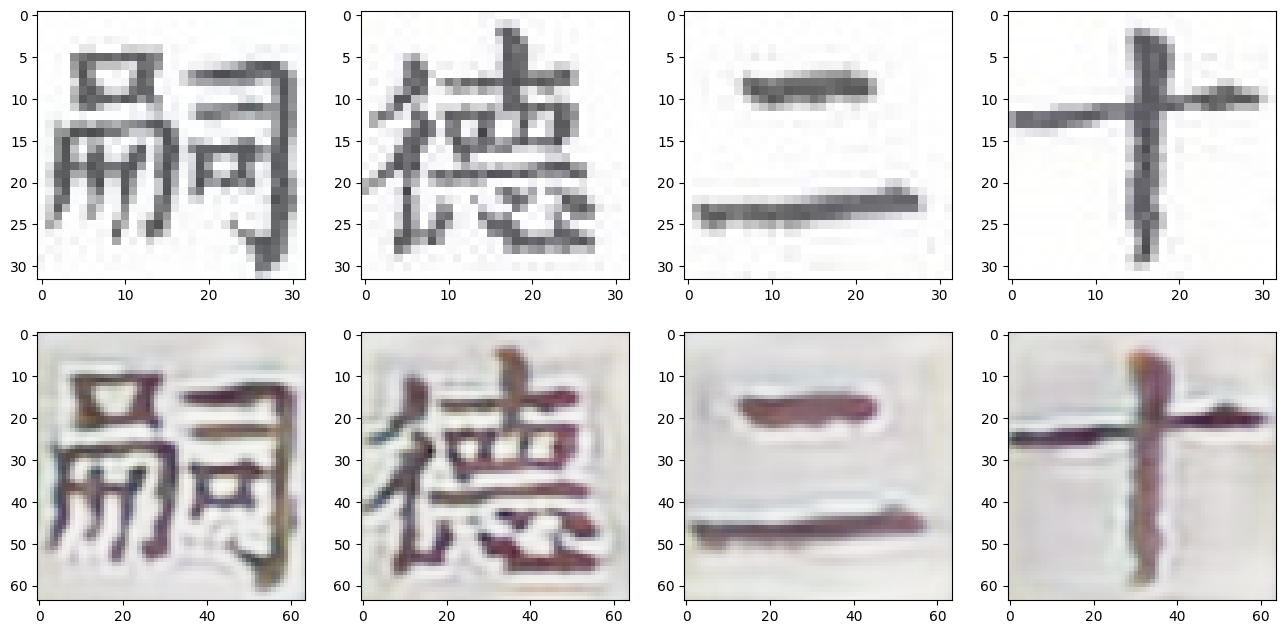

In [ ]:
sr_model.to('cpu')
recognizer_model.to('cpu')

DATASET_NAME = 'Tok1871'
dataset = NomImageDataset(
    image_dir = f'/content/dataset/{DATASET_NAME}_crops/{DATASET_NAME}_crops',
    annotation_file = f'/content/dataset/{DATASET_NAME}_crops/ToK1871_crops.txt',
    unicode_dict_path = UCODE_DICT,
    # scale=SCALE,
    image_size=(32, 32),
    transform = None,
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

label_dict = dict()
with open(UCODE_DICT, 'rb') as f:
    tmp = pickle.load(f)
for idx, (k, v) in enumerate(tmp.items()):
    label_dict[idx] = k

sample = next(iter(dataloader))
plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    img = sample[0][i].permute(1, 2, 0).numpy() * 255
    plt.imshow(sample[0][i].permute(1, 2, 0).numpy())

    grad_mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thres = np.array(grad_mask).mean()
    grad_mask = cv2.threshold(grad_mask, thres, 255, cv2.THRESH_BINARY)[1] / 255.0
    grad_mask = torch.tensor(grad_mask).unsqueeze(0)
    img_tensor = torch.cat((sample[0][i], grad_mask), dim=0).unsqueeze(0)

    sr_img = sr_model(img_tensor).squeeze().detach().cpu().permute(1, 2, 0).numpy()[:, :, :3]
    print(sr_img.shape)
    # Take first 3 channel
    plt.subplot(4, 4, i+5)
    plt.imshow(sr_img)

    # plt.title(sample[1][i].item())
    try:
        print(chr(int(label_dict[sample[1][i].item()], 16)), end=' ')
    except:
        print('UNK', end=' ')
plt.show()


torch.Size([3, 194, 31])
torch.Size([1, 194, 31])
tensor([[[0.9059, 0.9608, 0.9373,  ..., 0.8980, 0.9176, 0.8863],
         [0.8471, 0.8784, 0.8784,  ..., 0.9176, 0.9137, 0.9020],
         [0.9216, 0.8941, 0.8941,  ..., 0.9216, 0.8941, 0.8941],
         ...,
         [0.7608, 0.7529, 0.7569,  ..., 0.9333, 0.9137, 0.8941],
         [0.7647, 0.7647, 0.8118,  ..., 0.9255, 0.9176, 0.9020],
         [0.8392, 0.8196, 0.8588,  ..., 0.9412, 0.9412, 0.9216]],

        [[0.9059, 0.9608, 0.9373,  ..., 0.8980, 0.9176, 0.8863],
         [0.8471, 0.8784, 0.8784,  ..., 0.9176, 0.9137, 0.9020],
         [0.9216, 0.8941, 0.8941,  ..., 0.9216, 0.8941, 0.8941],
         ...,
         [0.7608, 0.7529, 0.7569,  ..., 0.9333, 0.9137, 0.8941],
         [0.7647, 0.7647, 0.8118,  ..., 0.9255, 0.9176, 0.9020],
         [0.8392, 0.8196, 0.8588,  ..., 0.9412, 0.9412, 0.9216]],

        [[0.9059, 0.9608, 0.9373,  ..., 0.8980, 0.9176, 0.8863],
         [0.8471, 0.8784, 0.8784,  ..., 0.9176, 0.9137, 0.9020],
        

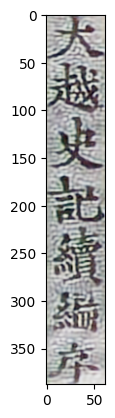

In [19]:
img_path = '/content/DVSKTT_thu_I_1a_0.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

grad_mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
thres = np.array(grad_mask).mean()
grad_mask = cv2.threshold(grad_mask, thres, 255, cv2.THRESH_BINARY)[1] / 255.0
img = torch.from_numpy(img).permute(2, 0, 1).div(255)
grad_mask = torch.tensor(grad_mask).unsqueeze(0)
print(img.shape)
print(grad_mask.shape)
img_tensor = torch.cat((img, grad_mask), dim=0).unsqueeze(0)
print(img)
print(grad_mask)
img_tensor = img_tensor.float()
with torch.no_grad():
    sr_img = sr_model(img_tensor).squeeze().detach().cpu().permute(1, 2, 0).numpy()[:, :, :3]

cv2.imwrite('sr_img.jpg', sr_img*255)
plt.imshow(sr_img)
plt.show()

## Test on Raw images

In [ ]:
torch.cuda.clear_cache()
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)

pbar = tqdm(total=len(dataloader), desc='Testing')

correct_pred = 0
incorrect_pred = []
for idx, (imgs, labels) in enumerate(dataloader, 1):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        # Essentially normal Resnet operation is inference on bicubic upscaled images
        bicubic_imgs = F.interpolate(imgs, size=(224, 224), mode='bicubic')
        bicubic_imgs = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(bicubic_imgs)


        preds = recognizer_model(bicubic_imgs)
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)

        correct_pred += torch.sum(preds == labels).item()
        # Record failure cases
        for i, (pred, label) in enumerate(zip(preds, labels)):
            if pred != label:
                incorrect_pred.append((f'{idx}_{i}', pred, label))
        pbar.update(1)

pbar.close()
print("\nAccuracy:", correct_pred / len(dataset))


Testing:  14%|█▍        | 64/452 [00:15<01:31,  4.25it/s]

Testing: 100%|██████████| 452/452 [01:11<00:00,  6.34it/s]


Accuracy: 0.7286505190311419


## Test on SR images

In [ ]:
torch.cuda.empty_cache()
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)

pbar = tqdm(total=len(dataloader), desc='Testing')

correct_pred = 0
incorrect_pred = []
for idx, (imgs, labels) in enumerate(dataloader, 1):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():

        grayscale = imgs.mean(dim=1, keepdim=True)
        threshold_value = grayscale.mean()
        threshold_tensor = (grayscale > threshold_value).float()
        imgs = torch.cat([imgs, threshold_tensor], dim=1)
        # print(imgs.shape)

        sr_imgs = sr_model(imgs)

        # Remove mask channel
        sr_imgs = sr_imgs[:, :3, :, :]
        # print(sr_imgs.shape)



        # Interpolate the image to 224x224
        sr_imgs = F.interpolate(sr_imgs, size=(224, 224), mode='bicubic')
        # print(sr_imgs.shape)
        sr_imgs = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(sr_imgs)


        preds = recognizer_model(sr_imgs)
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)

        correct_pred += torch.sum(preds == labels).item()
        # Record failure cases
        for i, (pred, label) in enumerate(zip(preds, labels)):
            if pred != label:
                incorrect_pred.append((f'{idx}_{i}', pred, label))
        pbar.update(1)

pbar.close()
print("\nAccuracy:", correct_pred / len(dataset))


Testing:   0%|          | 0/713 [00:00<?, ?it/s]


Accuracy: 0.8695194668537355


torch.Size([1, 3, 224, 224])
UNK torch.Size([1, 3, 224, 224])
UNK torch.Size([1, 3, 224, 224])
UNK torch.Size([1, 3, 224, 224])
UNK 

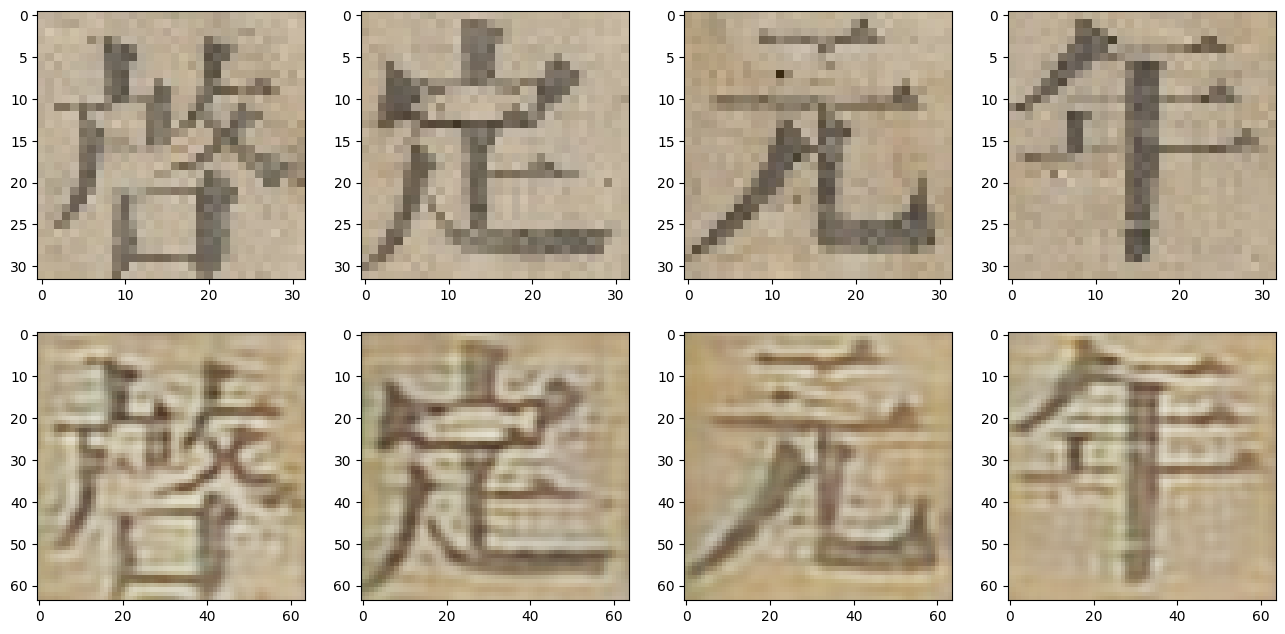

In [ ]:
sr_model.to('cpu')
recognizer_model.to('cpu')

sample = next(iter(dataloader))
plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    img = sample[0][i].permute(1, 2, 0).numpy() * 255
    plt.imshow(sample[0][i].permute(1, 2, 0).numpy())

    grad_mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thres = np.array(grad_mask).mean()
    grad_mask = cv2.threshold(grad_mask, thres, 255, cv2.THRESH_BINARY)[1] / 255.0
    grad_mask = torch.tensor(grad_mask).unsqueeze(0)
    img_tensor = torch.cat((sample[0][i], grad_mask), dim=0).unsqueeze(0)

    sr_img = sr_model(img_tensor)
    img = sr_img.squeeze().detach().cpu().permute(1, 2, 0).numpy()[:, :, :3]
    # print(sr_img.shape)
    # Take first 3 channel
    plt.subplot(4, 4, i+5)
    plt.imshow(img)

    # Prediction
    sr_img = sr_img[:, :3, :, :]
    sr_img = F.interpolate(sr_img, size=(224, 224), mode='bicubic')
    # print(sr_img.shape)
    sr_img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(sr_img)
    print(sr_img.shape)
    pred = recognizer_model(sr_img)
    pred = F.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)


    # plt.title(sample[1][i].item())
    try:
        print(chr(int(label_dict[preds.item()], 16)), end=' ')
    except:
        print('UNK', end=' ')

plt.show()